In [1]:
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('sbux.csv')

## This a snippet of a dataset from kaggle that ranges from February 2013 to February 2018

### Finance Trade Stock Intuition
  - Its a number and each day its a new number
  - It starts early in the morning and closes at the end of the trading day
  - price values are in the tens and volume is in the 100000s
  -

In [2]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [3]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [4]:
# Trying to predict the price itself - Start by doing the wrong thing
series = df['close'].values.reshape(-1, 1)

In [5]:
# Normalize the data
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [6]:
### Single time series to predict time series
### We built the dataset
# Using T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Data should be N X T X D
Y = np.array(Y)
N = len(X)
print(f'X.Shape {X.shape}, Y.shape {Y.shape}')

X.Shape (1249, 10, 1), Y.shape (1249,)


In [7]:
### Autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
    loss='mse',
    optimizer=Adam(lr=0.1),
)

# train the RNN
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data = (X[-N//2:], Y[-N//2:])
)

Epoch 1/80
20/20 [==============================] - 8s 91ms/step - loss: 0.2615 - val_loss: 2.5153
Epoch 2/80
20/20 [==============================] - 0s 22ms/step - loss: 0.1982 - val_loss: 2.0543
Epoch 3/80
20/20 [==============================] - 1s 43ms/step - loss: 0.1504 - val_loss: 1.6122
Epoch 4/80
20/20 [==============================] - 1s 26ms/step - loss: 0.1160 - val_loss: 1.2863
Epoch 5/80
20/20 [==============================] - 0s 18ms/step - loss: 0.0972 - val_loss: 1.0534
Epoch 6/80
20/20 [==============================] - 0s 20ms/step - loss: 0.0854 - val_loss: 0.8821
Epoch 7/80
20/20 [==============================] - 0s 19ms/step - loss: 0.0764 - val_loss: 0.7856
Epoch 8/80
20/20 [==============================] - 0s 12ms/step - loss: 0.0689 - val_loss: 0.7127
Epoch 9/80
20/20 [==============================] - 0s 10ms/step - loss: 0.0624 - val_loss: 0.6505
Epoch 10/80
20/20 [==============================] - 0s 12ms/step - loss: 0.0569 - val_loss: 0.5643
Epoch 11/

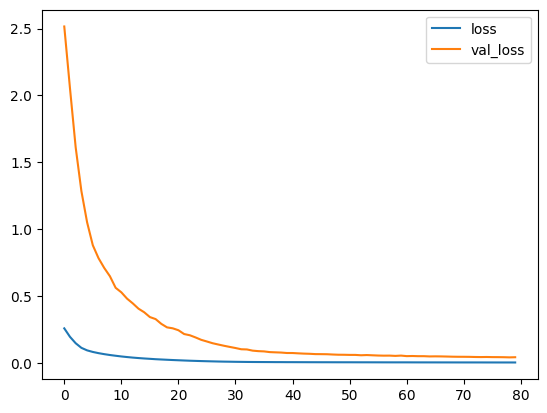

In [8]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

40/40 [==============================] - 1s 2ms/step
(1249, 1)


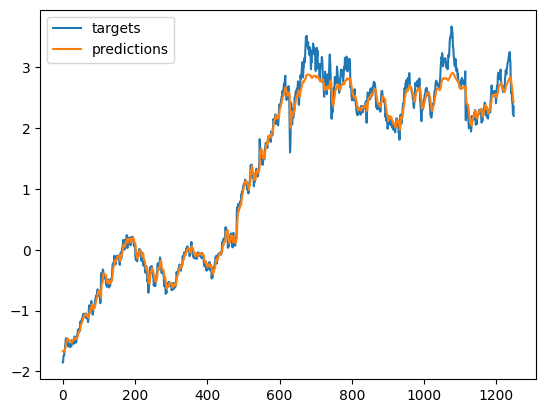

In [9]:
# One step forecasting using the targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:, 0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

1/1 [==============================] - 0s 24ms/step


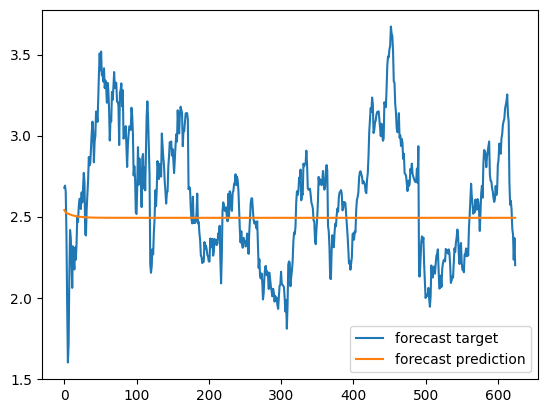

In [10]:
# Forecasting - Mult-Step
validation_target = Y[-N//2:] # This line selects the last half of the Y data to be the target for validation.
validation_predictions = [] # This line creates an empty list where the predictions will be stored.

# last train input
last_x = X[-N//2] # 1-D array of lengh  T, This line gets the last sequence of data from X to start making predictions.
while len(validation_predictions) < len(validation_target): # loop continues until the number of predictions matches the number of targets. Inside the loop
  p = model.predict(last_x.reshape(1, T, 1))[0][0] # 1x1 array <- scalar, The model makes a prediction based on last_x, and p is the predicted value.

  # Prediction list gets updated
  validation_predictions.append(p) # The predicted value p is added to the list of predictions.

  # New input is made
  last_x = np.roll(last_x, -1) #  The values in last_x are shifted to the left by one position.
  last_x[-1] = p # The predicted value p is added to the end of last_x to be used for the next prediction
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

## As we can see, the problem lies in that, the model is not predicting the next value in the time series instead it is just copying the previous value. And that makes sense for time series, as the data is highly correlated.

## What we learnt is that one-step prediction on stock prices is misleading and is also not conventional. To solve the problem, what should matter to us more is the **Stock Returns**

- Given by R = V(final)- V(initial) / V(initial)

### For example, what does it mean for something to be 20% off.
### Intuitively, if something costs $ 100, and is 20 % off, you'll pay $80

- 80 - 100 / 100 = - 20%

In [11]:
# Calculate returns by first shifting the data

df['PrevClose'] = df['close'].shift(1) # Move everything up 1

# so now its like
# close / prev close
# x[2] x[1]
# x[3] x[2]
# x[4] x[3]
# ...
# x[t] x[t-1] # we do it so that yesterdays closing price align with today's closing price

In [12]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [13]:
# Return calculation
# x[t] - x[t-1] / x[t-1]
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']

In [14]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


<Axes: >

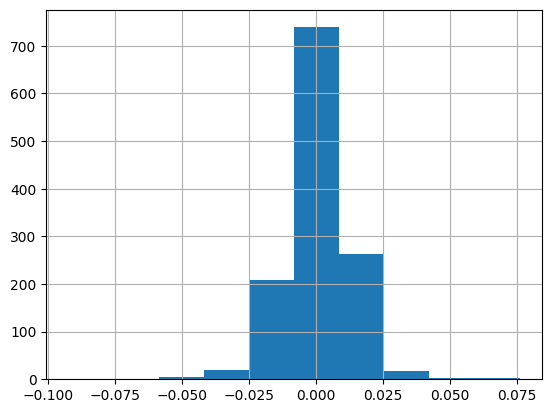

In [15]:
# Predicting returns via the use of LSTM
df['Return'].hist()

### As we can see via the histogram the values are pretty small, so we can normalize them

In [16]:
series = df['Return'].values[1:].reshape(-1, 1)

# Normalize the data
# Note: I didnt think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [17]:
### building the dataset
# let's see if we can use T past values to predict the next value
T = 10 # Time stamp window
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)
X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1248, 10, 1) Y.shape (1248,)


In [18]:
### Try autoregressive RNN Model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
    loss = 'mse',
    optimizer=Adam(lr=0.01),
)
# train the RNN
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
20/20 [==============================] - 3s 37ms/step - loss: 0.9878 - val_loss: 1.1348
Epoch 2/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9868 - val_loss: 1.1358
Epoch 3/80
20/20 [==============================] - 0s 11ms/step - loss: 0.9861 - val_loss: 1.1379
Epoch 4/80
20/20 [==============================] - 0s 11ms/step - loss: 0.9858 - val_loss: 1.1389
Epoch 5/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9854 - val_loss: 1.1384
Epoch 6/80
20/20 [==============================] - 0s 11ms/step - loss: 0.9854 - val_loss: 1.1385
Epoch 7/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9854 - val_loss: 1.1408
Epoch 8/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9846 - val_loss: 1.1403
Epoch 9/80
20/20 [==============================] - 0s 18ms/step - loss: 0.9845 - val_loss: 1.1416
Epoch 10/80
20/20 [==============================] - 0s 14ms/step - loss: 0.9846 - val_loss: 1.1406
Epoch 11/

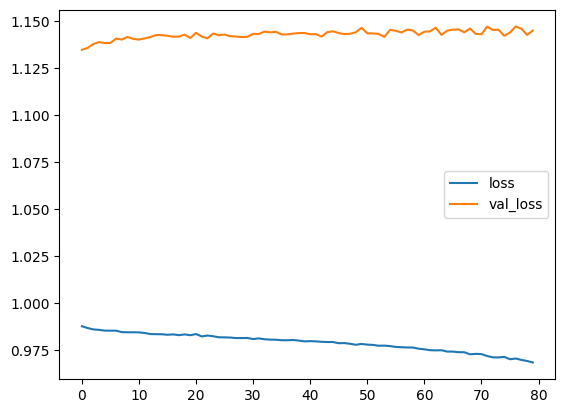

In [19]:
# Per Iteration Plot the losses
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

In [20]:
# As we can see training loss is slightly going down but validation loss is on the contrary
# increasing



39/39 [==============================] - 1s 2ms/step
(1248, 1)


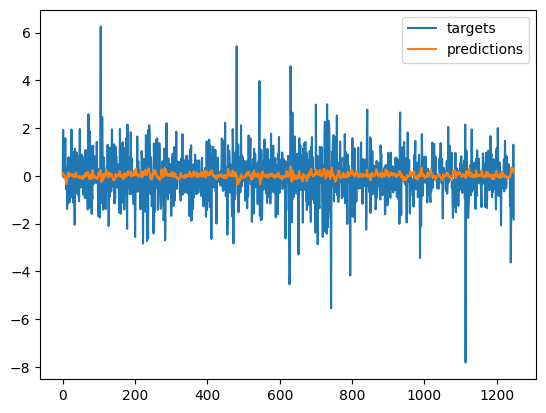

In [21]:
# One Step forecasting using true targets
outputs= model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

## As we can see the model has not learnt the true target at all, its just a waste model, lets try next the multi forecast

1/1 [==============================] - 0s 24ms/step


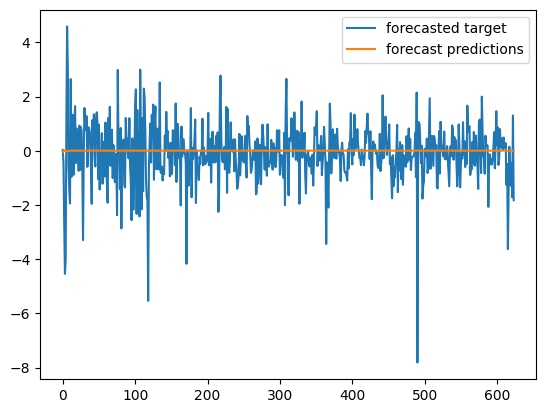

In [22]:
# Multi Step Forecasting
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X[-N//2] # 1-d Array of Length T

while len(validation_predictions) < len(validation_target):
  p= model.predict(last_x.reshape(1, T, 1))[0, 0] # 1x1 array which is a scalar

  # prediction list updated
  validation_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecasted target')
plt.plot(validation_predictions, label='forecast predictions')
plt.legend()


## Again we see that model is not able to do much except copy the previous value over and over again

**OUR FINAL MODEL**

### In this model we will not predict returns , we will predict whether the future price will go up or low, in short binary classification (a common approach in Finance)

### We will make use of all the data: open, high, low, close, volumne (D=5). In binary classification we just have to predict labels, which is easier than predicting exact number

In [23]:
# Convert all data into numpy arrays
# which is not in the final 'X' format!
input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['Return'].values

In [24]:
# Now using the neural networks, make the actual data
T = 10 # Number of time steps to watch out in making prediction for the next day
D = input_data.shape[1]
N = len(input_data) - T # (e.g. if T =10 and you have 11 data points then you'd only have 1 subtracted from the time step and length of the window size )


In [25]:
# Normalizing our inputs
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T])
input_data = scaler.transform(input_data)

In [26]:
# Setup S_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t: t+T]
  Y_train[t] = (targets[t+T] > 0)


In [27]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
  # Couting u from 0...( N- Ntrain)
  # counting t from Ntrain...N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [28]:
# RNN network in implementation
i = Input(shape=(T, D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
    loss = 'binary_crossentropy',
    optimizer=Adam(lr=0.001),
    metrics= ['accuracy'],
)

In [29]:
# Training the RNN
r = model.fit(
    X_train, Y_train,
    batch_size = 332,
    epochs=300,
    validation_data=(X_test, Y_test),
)

Epoch 1/300
3/3 [==============================] - 4s 350ms/step - loss: 0.7011 - accuracy: 0.4982 - val_loss: 0.6937 - val_accuracy: 0.5146
Epoch 2/300
3/3 [==============================] - 0s 53ms/step - loss: 0.6931 - accuracy: 0.5244 - val_loss: 0.6966 - val_accuracy: 0.4805
Epoch 3/300
3/3 [==============================] - 0s 46ms/step - loss: 0.6917 - accuracy: 0.5244 - val_loss: 0.7017 - val_accuracy: 0.4854
Epoch 4/300
3/3 [==============================] - 0s 45ms/step - loss: 0.6920 - accuracy: 0.5268 - val_loss: 0.7023 - val_accuracy: 0.4902
Epoch 5/300
3/3 [==============================] - 0s 39ms/step - loss: 0.6922 - accuracy: 0.5161 - val_loss: 0.7005 - val_accuracy: 0.4902
Epoch 6/300
3/3 [==============================] - 0s 42ms/step - loss: 0.6914 - accuracy: 0.5209 - val_loss: 0.6988 - val_accuracy: 0.4902
Epoch 7/300
3/3 [==============================] - 0s 63ms/step - loss: 0.6905 - accuracy: 0.5304 - val_loss: 0.6975 - val_accuracy: 0.4902
Epoch 8/300
3/3 [==

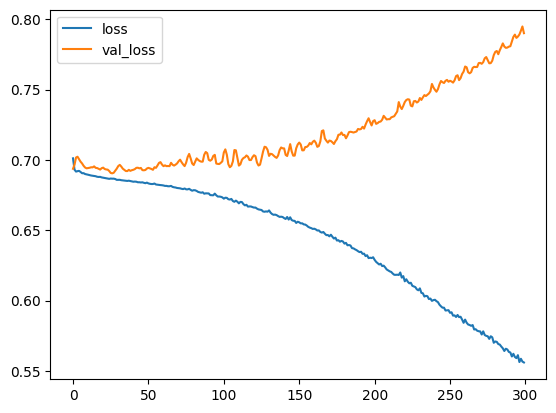

In [30]:
# plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


**What we see here, is that training loss goes down a little bit but validation loss goes up a lot, which means our model is overfitting to the noise of the training set**

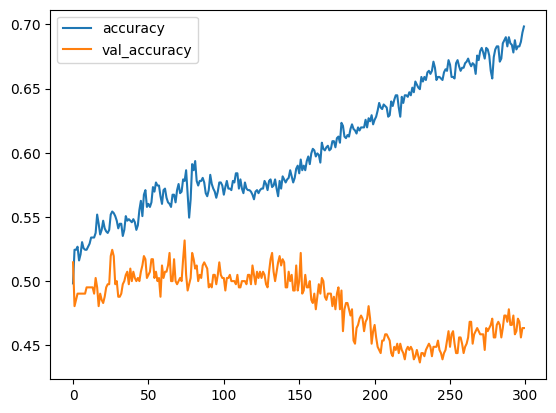

In [32]:
# Plotting the accuracy per iterations
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

### What we see here is that train accuracy goes up but test accuracy stays the same at 50%.

### Now you may wonder why the train accuracy is going up but validation accuracy stays at 50%. It is important to note that in Binary classification is that 0 accuracy is not the worst accuracy, if your accuracy is 0 then you can reverse all your predictions and you get 100% accuracy. The worst accuracy in binary classification is 50%, which means the model is doing nothing except random guessing.

##In this project, we explored LSTM, stock return prediction, and binary classification methods for predicting Starbucks’ stock prices. Despite the advancements in machine learning, the results underscored the complexity of stock markets and the limitations of these techniques in predicting market trends. The project served as a reminder of the challenges in this domain and the areas where machine learning still struggles.